<div style="border: 2px solid #255c8a; padding: 10px; background-color: #121212; border-radius: 5px; line-height: 1; width: 97%">
  <strong> ℹ️ Descrição:</strong> 
  Finalmente, temos provavelmente a tarefa mais complicada desta EDA: o tratamento dos dados com NaN`s
</div>

# Inicialização

**Bibliotecas**:

In [782]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

**Funções Auxiliares:**

In [783]:
sys.path.append(os.path.abspath("../src"))
from AnaliseExploratoria_functions import histogram_and_stats, evaluate_distribution, impute_missing_values

**Leitura do Arquivo:**

In [784]:
current_path = os.path.dirname(os.getcwd())
csv_path = (current_path + '/Data/campeonatos_futebol_sem_outliers.csv')

df = pd.read_csv(csv_path)

# Análise preliminar

Abaixo, refazemos uma análise feita em "[1] Análise Inicial", em que mostramos a % de NaNs em cada coluna:

In [785]:
nan_percent = df.isna().mean() * 100
print(nan_percent.sort_values(ascending=False))

Tratamentos 2          81.834119
Tratamentos 1          81.834119
Defesas difíceis 1     77.422300
Defesas difíceis 2     77.422300
Contra-ataques 1       77.312735
Contra-ataques 2       77.312735
Tiros-livres 2         77.239692
Tiros-livres 1         77.239692
Chutes bloqueados 2    67.926664
Chutes bloqueados 1    67.926664
Cruzamentos 1          67.320405
Cruzamentos 2          67.320405
Substituições 1        66.096929
Substituições 2        66.096929
Tiro de meta 1         56.338337
Tiro de meta 2         56.338337
Laterais 2             44.892444
Laterais 1             44.892444
Impedimentos 1         10.069026
Impedimentos 2         10.069026
Posse 1(%)              8.564333
Posse 2(%)              8.564333
Escanteios 2            8.443811
Escanteios 1            8.443811
Chutes fora 1           8.432855
Chutes fora 2           8.432855
Faltas 1                8.425551
Faltas 2                8.425551
Position 2              5.799642
Position 1              5.722947
Chutes a g

Igualmente, mostraremos a matriz de correlação:

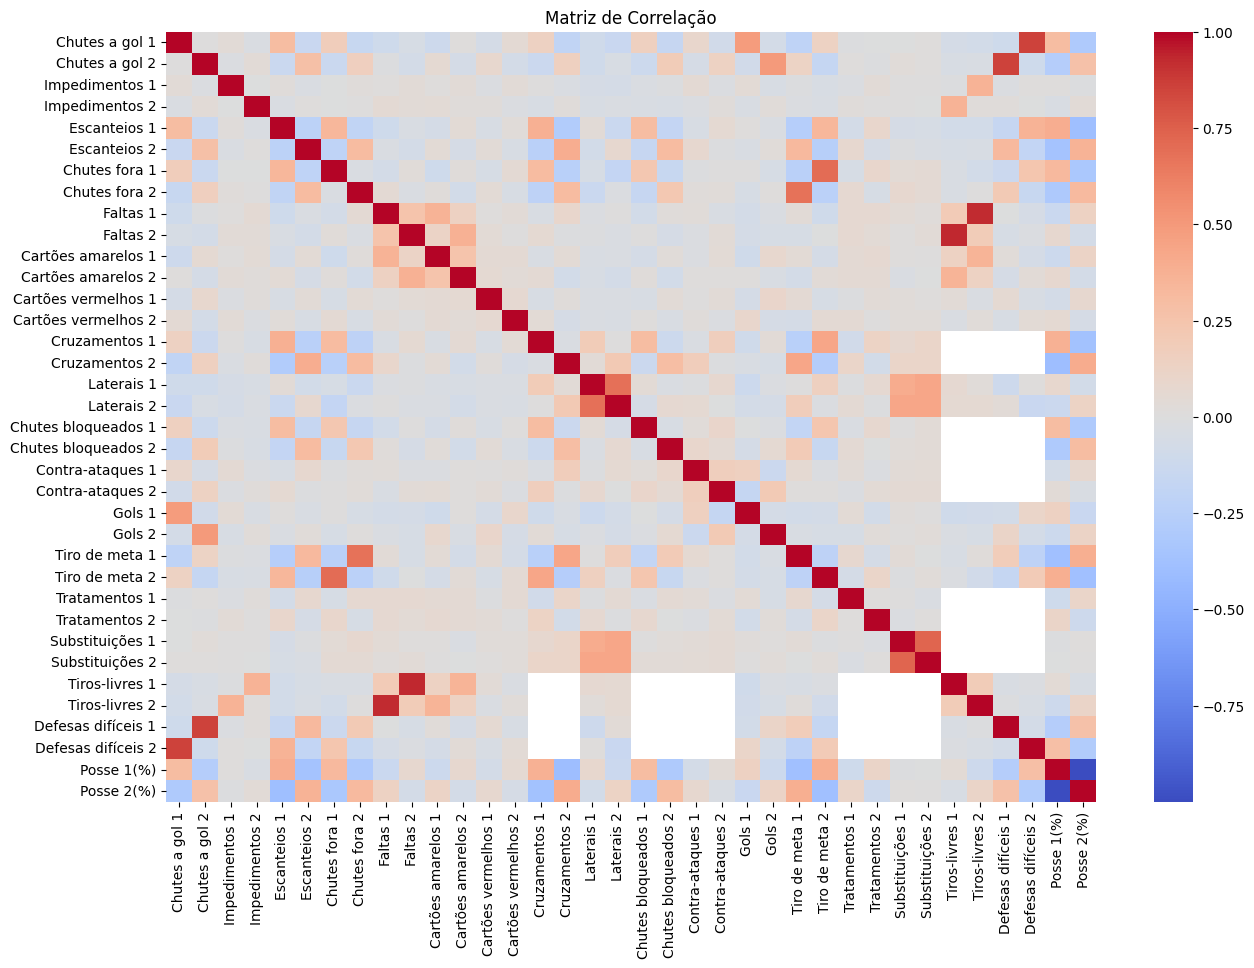

In [786]:
correlacao = df.select_dtypes(include="number").corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlacao, annot=False, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlação")
plt.show()

# Estratégias para lidar com os NaN

O grupo pensou emm algumas estratégias para lidarmos com os NaN. Ao final, chegamos nas seguintes ideias:

- Eliminar as colunas que possuem muitos NaN  
- Inputar, por média/mediana, ou usando o KNN Inputer, as colunas que possuem poucos NaN
- Encontrar relações entre as variáveis, de forma a reduzir a quantidade de colunas sendo usadas (crair índices)

# Retirando colunas

Como parte do tratamento de NaN, o grupo discutiu o impacto que as variáveis que possuem alto índice de dados faltantes realmente faria no modelo. 

Por exemplo, questionamos a utilidade dos dados de tratamento médico, visto que são poucas informações, e não é possível saber a seriedade da lesão, nem a importância que o jogador que necessitou de tratamento tem para o time. Assim, decidimos por eliminá-la. 

Igualmente, retiramos a coluna de defesas difíceis, visto que temos poucos dados sobre ela, além de ser difícil de descobrir o que este dado realmente representa (o quão difícil a defesa realmente foi).

Também retiramos a variável de tiros-livres, visto que esta coluna possui uma alta dependência com a quantidade de faltas feitas durante o jogo. Ademais, vamos retirar todas as entradas que possuem NaN na coluna de posição.

Por fim, já havíamos retirado a variável com o nome dos times, por ser desprezível para o resultado final. 


In [ ]:
df = df.drop('Tiros-livres 1', axis=1)
df = df.drop('Tiros-livres 2', axis=1)
df = df.drop('Tratamentos 1', axis=1)
df = df.drop('Tratamentos 2', axis=1)
# df = df.drop('Defesas difíceis 1', axis=1) # Linha comentada para o teste 3 (com as defesas difíceis)
# df = df.drop('Defesas difíceis 2', axis=1) # Linha comentada para o teste 3 (com as defesas difíceis) 
df = df.dropna(subset=['Position 1', 'Position 2'])

Antes de seguir, faremos cópias do data frame, para podermos controlá-lo melhor ao decorrer das estratégias

In [788]:
df_1 = df.copy() #usado pela média diretamente nas colunas com poucos NaN + eliminar colunas com muito NaN
df_2 = df.copy() #usado para o KNN Inputer nas colunas com poucos NaN + eliminar colunas com muito NaN
df_3 = df.copy() #usado para inputar (média, mediana ou KNN) nas colunas com poucos NaN + índices para as colunas com muitos NaN

# Inputando valores

Para as colunas que possuem apenas poucas entradas faltando, podemos simplesmente analisar o restante do data frame, e imputar um valor padrão para elas. Neste caso, utilizaremos a média/mediana. 

Antes disso, entretanto, é interessante analisarmos a distribuição das variáveis, para checarmos se a média/mediana realmente seria uma opção válida (e ver se alguma das duas é melhor). Para isso, utilizamos três gráficos: o da distribuição, um Q-Q, e um boxplot.

> OBS: talvez o boxplot fosse mais interessante no arquivo dos outliers? Já que ele é principalmente utilizado para isso.

Faremos isso para as colunas que não possuam mais de 10% de NaN, isto é:

- Impedimentos
- Posse
- Escanteios
- Chutes fora
- Faltas
- Chutes a gol

In [789]:
colunas_avaliar = ['Chutes a gol 1', 'Chutes a gol 2', 'Impedimentos 1', 'Impedimentos 2',
                   'Escanteios 1', 'Escanteios 2', 'Chutes fora 1', 'Chutes fora 2',
                   'Faltas 1', 'Faltas 2', 'Posse 1(%)', 'Posse 2(%)']

In [790]:
# Interpretação:
    # Skewness:
    #   - Se ~0, a distribuição é simétrica.
    #   - Se positivo, a cauda direita é mais longa, indicando assimetria à direita.
    #   - Se negativo, a cauda esquerda é mais longa, indicando assimetria à esquerda.
    #
    # Kurtosis:
    #   - Para uma distribuição normal, o excesso de kurtosis é 0 (pois a kurtosis normal é 3).
    #   - Valores positivos indicam caudas mais pesadas (mais outliers) que uma normal.
    #   - Valores negativos indicam caudas mais leves que uma normal.

**Chutes a gol**

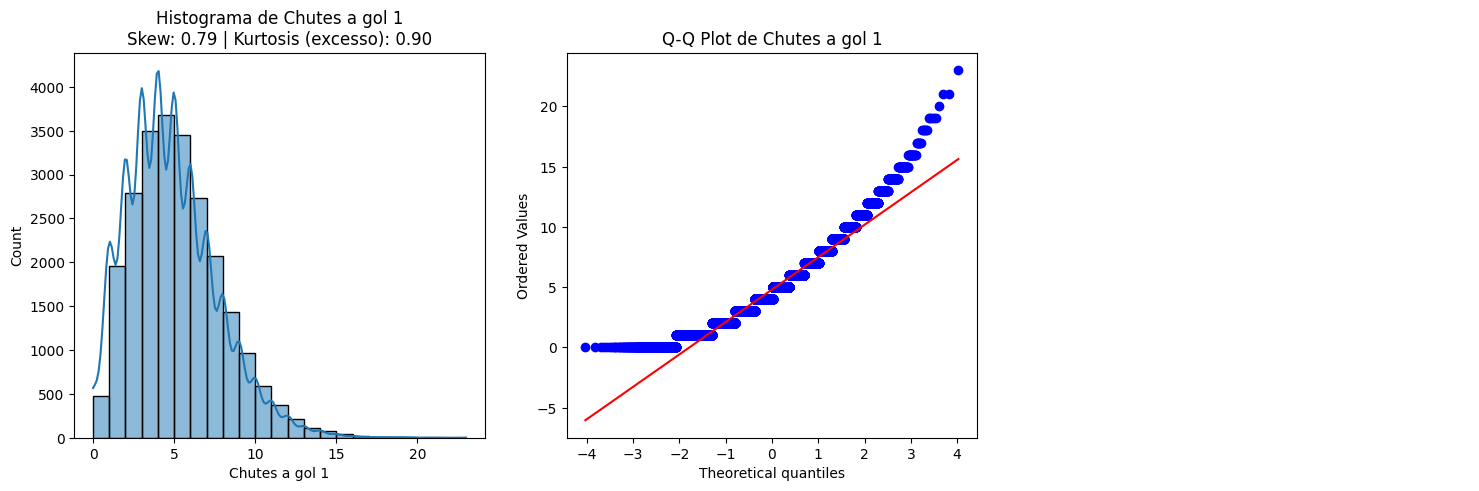


Coluna: Chutes a gol 1
Skewness: 0.785
Kurtosis (excesso): 0.903


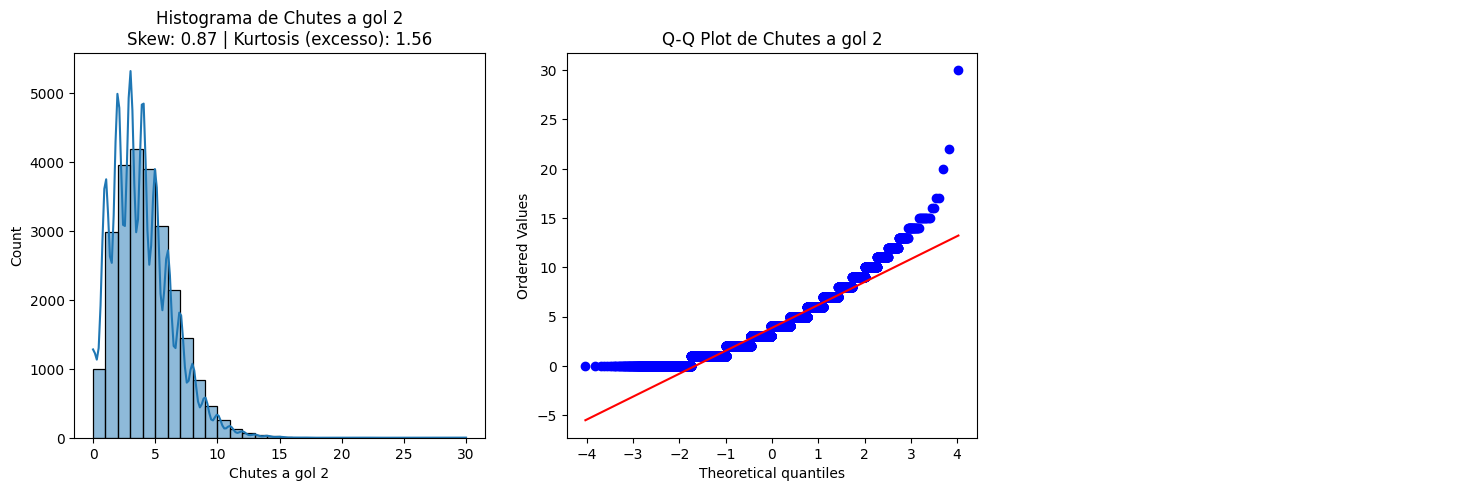


Coluna: Chutes a gol 2
Skewness: 0.873
Kurtosis (excesso): 1.563


{'skewness': np.float64(0.872866925150647),
 'kurtosis': np.float64(1.562536968684705)}

In [791]:
evaluate_distribution(df, colunas_avaliar[0], bins = 23)
evaluate_distribution(df, colunas_avaliar[1], bins = 30)

**Impedimentos**

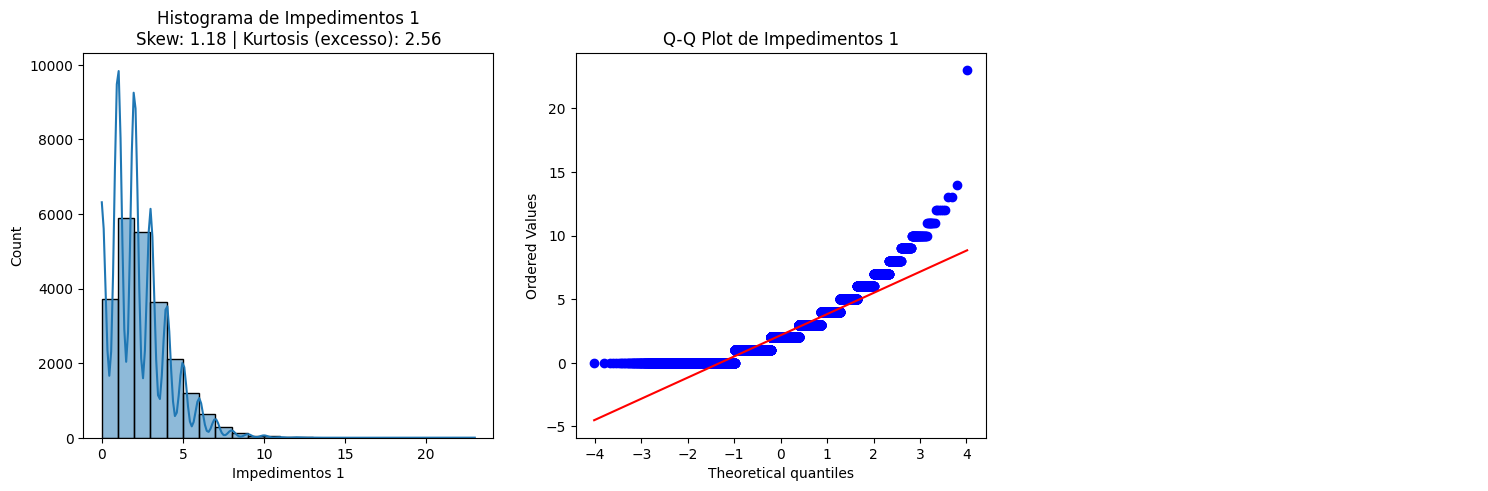


Coluna: Impedimentos 1
Skewness: 1.181
Kurtosis (excesso): 2.562


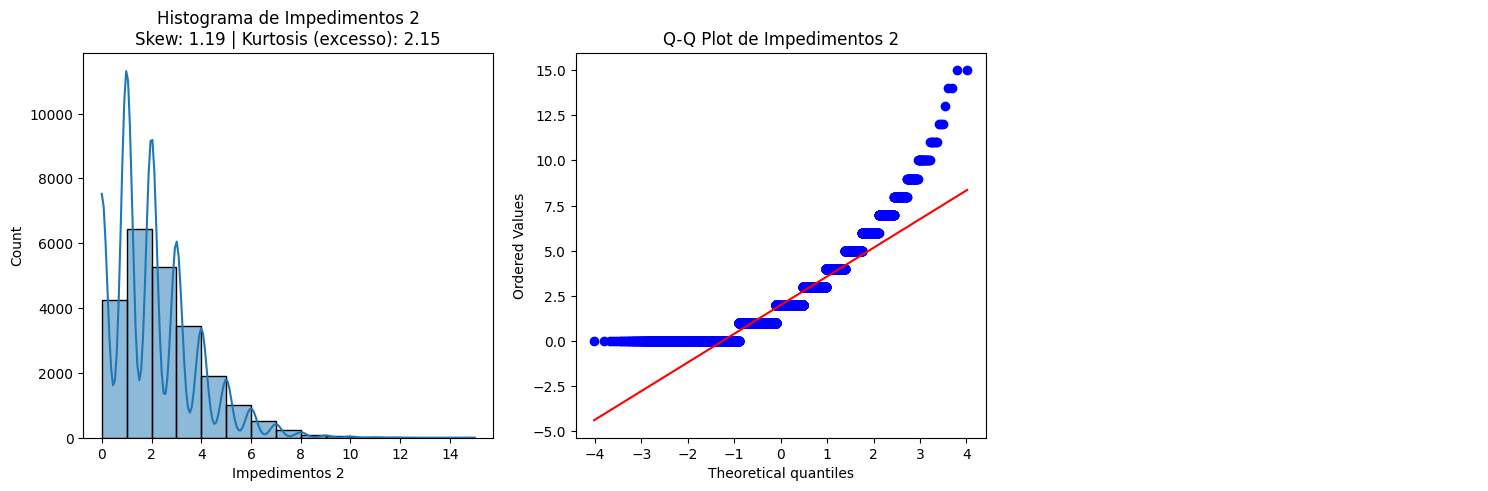


Coluna: Impedimentos 2
Skewness: 1.186
Kurtosis (excesso): 2.151


{'skewness': np.float64(1.1860724193218164),
 'kurtosis': np.float64(2.150730591517508)}

In [792]:
evaluate_distribution(df, colunas_avaliar[2], bins = 23)
evaluate_distribution(df, colunas_avaliar[3], bins = 15)

**Escanteios**

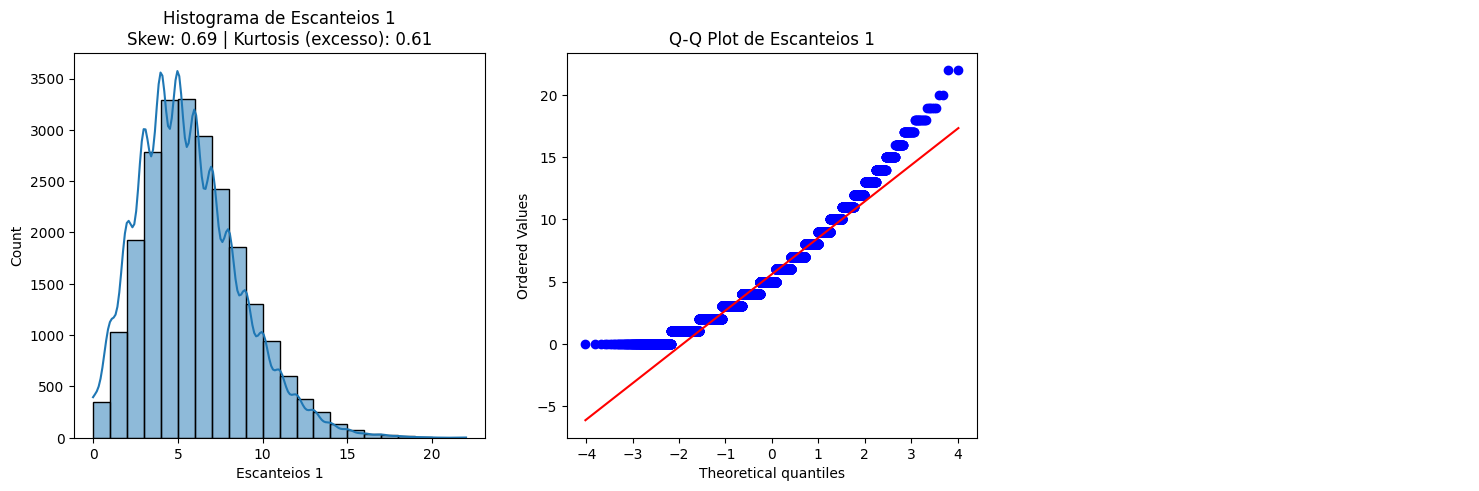


Coluna: Escanteios 1
Skewness: 0.688
Kurtosis (excesso): 0.606


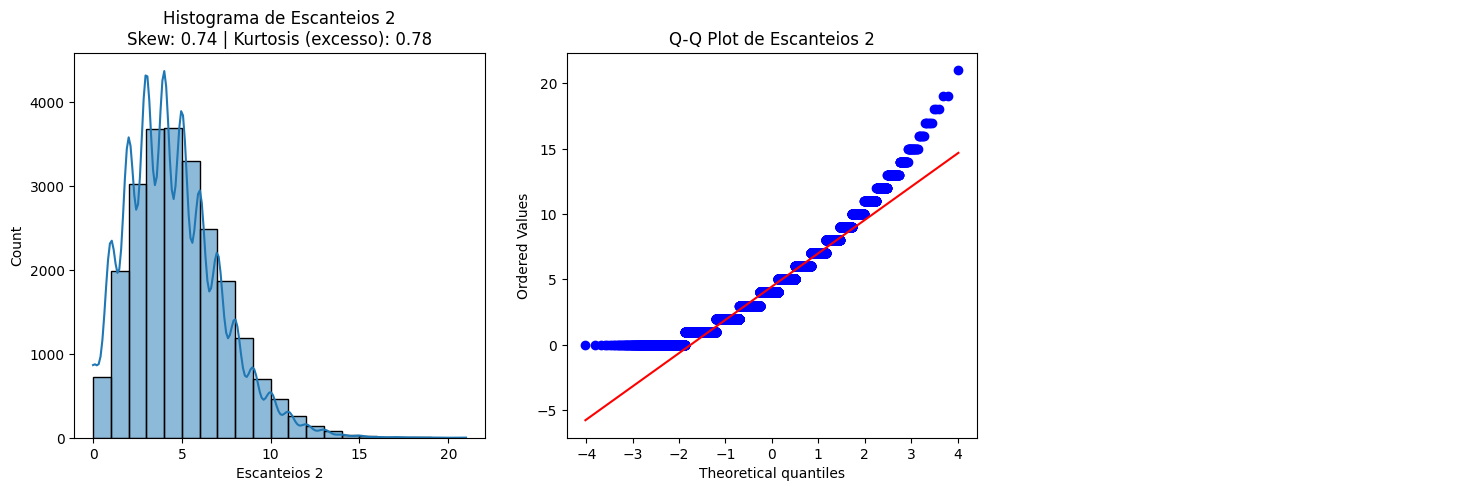


Coluna: Escanteios 2
Skewness: 0.742
Kurtosis (excesso): 0.782


{'skewness': np.float64(0.742015556602586),
 'kurtosis': np.float64(0.7818237865637476)}

In [793]:
evaluate_distribution(df, colunas_avaliar[4], bins = 22)
evaluate_distribution(df, colunas_avaliar[5], bins = 21)

**Chutes fora**

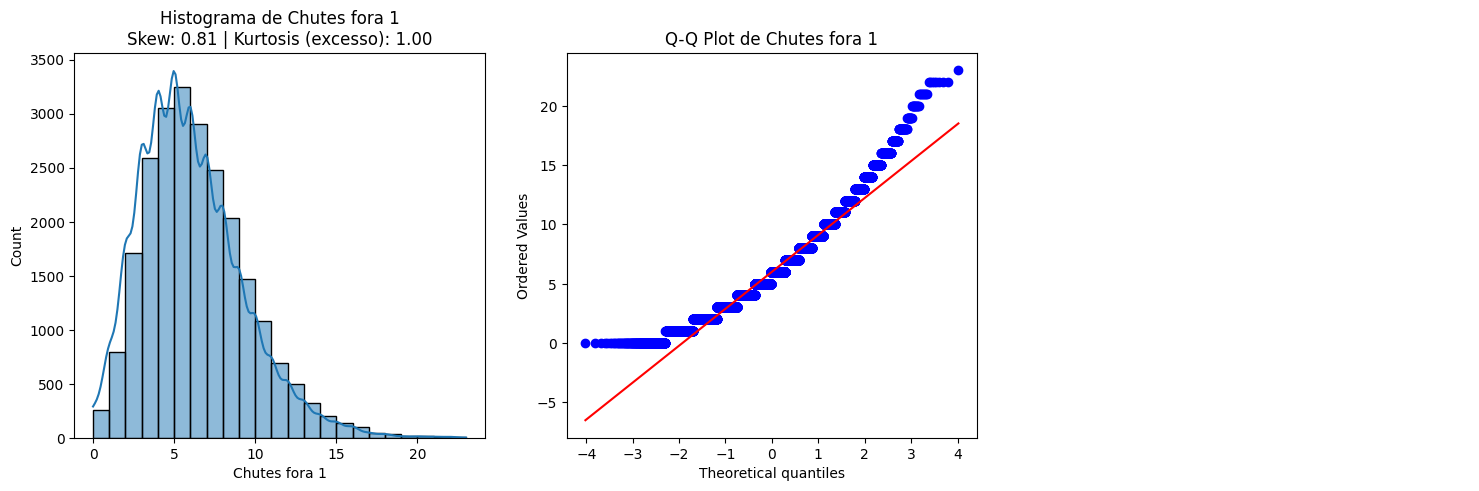


Coluna: Chutes fora 1
Skewness: 0.811
Kurtosis (excesso): 0.997


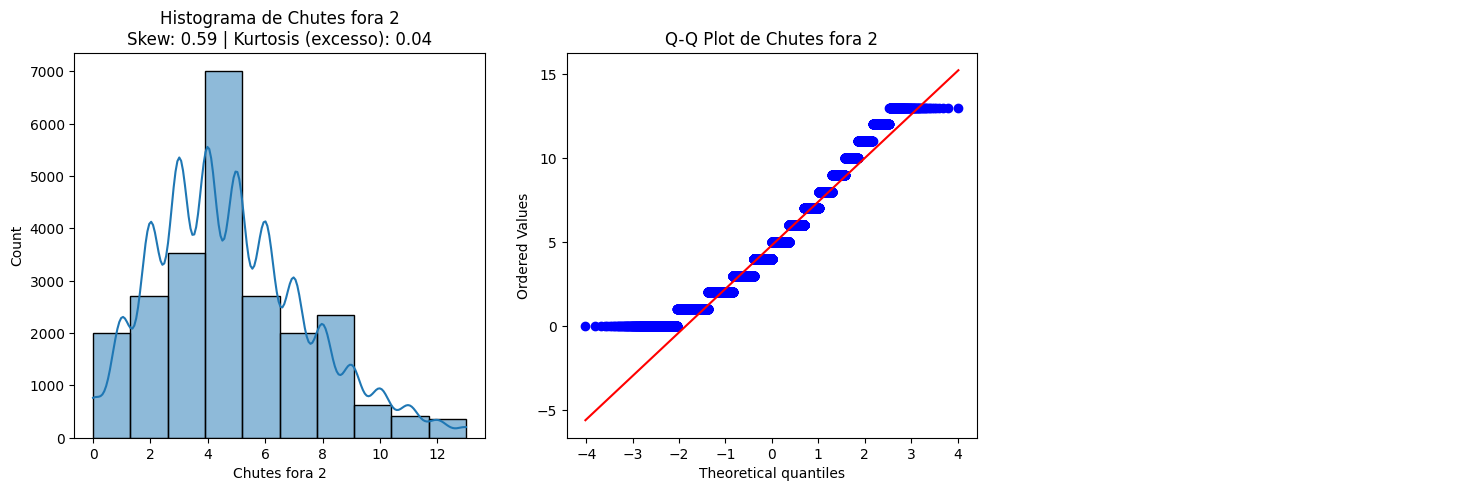


Coluna: Chutes fora 2
Skewness: 0.589
Kurtosis (excesso): 0.041


{'skewness': np.float64(0.5890529018696015),
 'kurtosis': np.float64(0.04070829843560109)}

In [794]:
evaluate_distribution(df, colunas_avaliar[6], bins = 23)
evaluate_distribution(df_1, colunas_avaliar[7], bins = 10)

**Faltas**

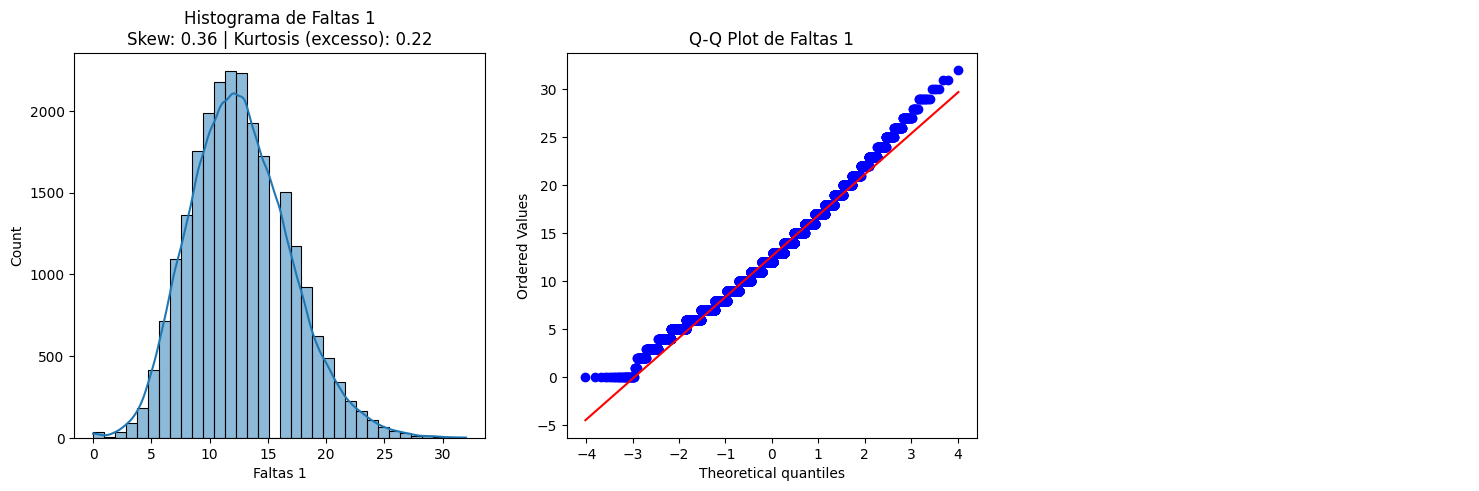


Coluna: Faltas 1
Skewness: 0.359
Kurtosis (excesso): 0.215


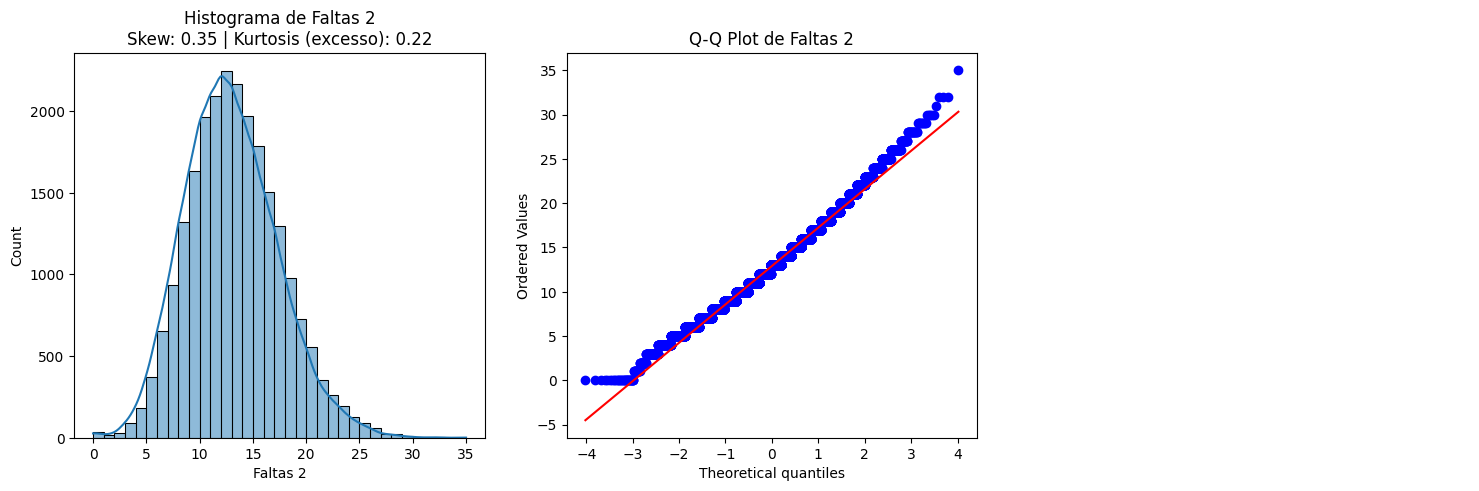


Coluna: Faltas 2
Skewness: 0.349
Kurtosis (excesso): 0.217


{'skewness': np.float64(0.3485276513990692),
 'kurtosis': np.float64(0.21652569369345986)}

In [795]:
evaluate_distribution(df, colunas_avaliar[8], bins = 34)
evaluate_distribution(df, colunas_avaliar[9], bins = 35)

**Posse de bola**

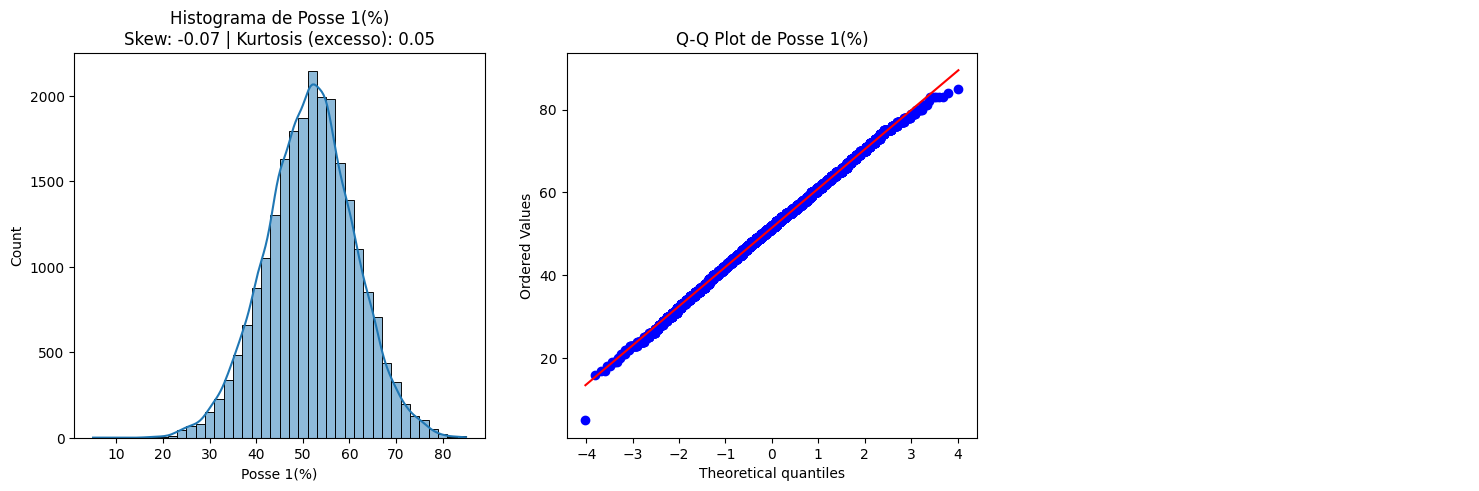


Coluna: Posse 1(%)
Skewness: -0.070
Kurtosis (excesso): 0.055


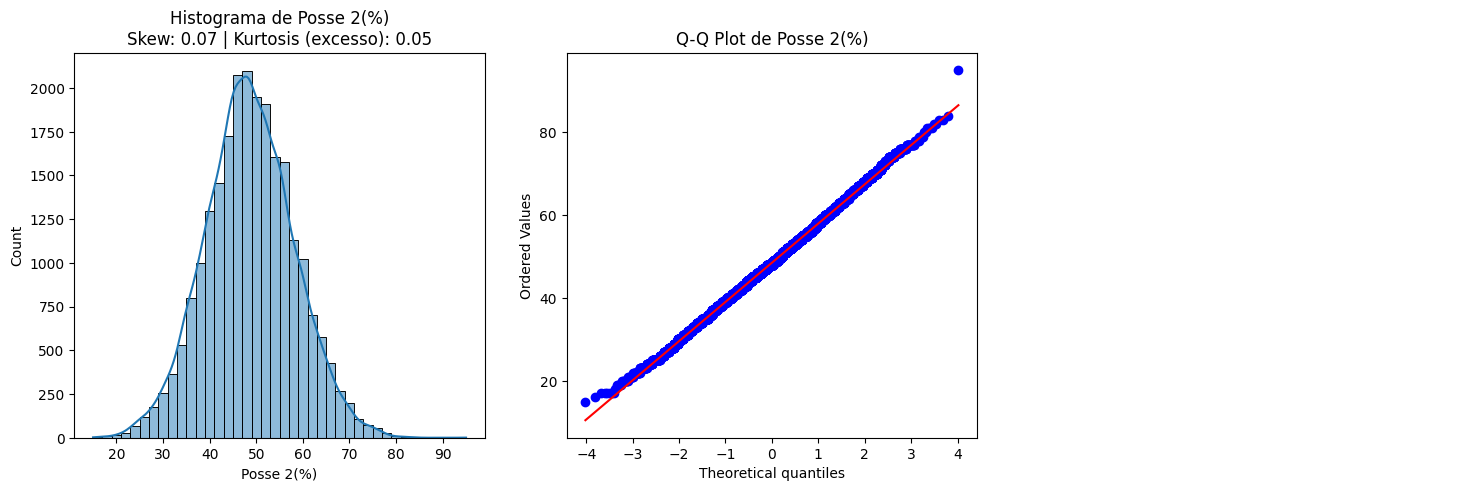


Coluna: Posse 2(%)
Skewness: 0.070
Kurtosis (excesso): 0.055


{'skewness': np.float64(0.07013893951591604),
 'kurtosis': np.float64(0.0547355424453162)}

In [796]:
evaluate_distribution(df, colunas_avaliar[10])
evaluate_distribution(df, colunas_avaliar[11])

Analisando os gráficos acima, vemos que todas as variáveis apresentam distribuições próximas da normal. Então, faremos a substituição pela média

In [797]:
for coluna in colunas_avaliar:
    valor_preenchimento = df_1[coluna].mean() 
    df_1.fillna({coluna: valor_preenchimento}, inplace=True) 

Alternativamente, podemos fazer o inpute pelo KNN inputer:

In [798]:
# # Colunas que vão passar pela transformação
# cols_to_impute = df.select_dtypes(include="number")

# # Pipeline de normalização + imputação
# knn_pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('imputer', KNNImputer(n_neighbors=2))
# ])

# # Aplica apenas às colunas selecionadas
# column_transformer = ColumnTransformer(
#     transformers=[
#         ('knn_impute', knn_pipeline, cols_to_impute)
#     ],
#     remainder='passthrough'  # Mantém as outras colunas como estão
# )

# # Aplicando
# data_transformed = column_transformer.fit_transform(df)

# # Recuperando as colunas na ordem corretaz
# # (ColumnTransformer embaralha a ordem às vezes)
# new_columns = cols_to_impute + [col for col in df.columns if col not in cols_to_impute]
# df_2 = pd.DataFrame(data_transformed, columns=new_columns)

#### Inputando valores para Defesas difíceis (teste 4)

# Ideia 1: Eliminar colunas com muitos NaN

Como uma estratégia bastante simples, podemos eliminar as colunas que possuem muitos NaN. Afinal de contas, temos pouquíssimos dados para podermos inferir uma média ou padrão a partir deles, então é extremamente difícil conseguir utilizá-los na prática.

As colunas que serão eliminadas são aquelas que possuem mais de 40% de NaN na análise preliminar, e ainda não foram excluídos:

- Contra-ataques
- Chutes bloqueados
- Cruzamentos
- Substituições
- Tiro de meta
- Laterais

In [799]:
df_1 = df_1.drop('Contra-ataques 1', axis=1)
df_1 = df_1.drop('Contra-ataques 2', axis=1)
df_1 = df_1.drop('Chutes bloqueados 1', axis=1)
df_1 = df_1.drop('Chutes bloqueados 2', axis=1)
df_1 = df_1.drop('Cruzamentos 1', axis=1)
df_1 = df_1.drop('Cruzamentos 2', axis=1)
df_1 = df_1.drop('Substituições 1', axis=1)
df_1 = df_1.drop('Substituições 2', axis=1)
df_1 = df_1.drop('Tiro de meta 1', axis=1)
df_1 = df_1.drop('Tiro de meta 2', axis=1)
df_1 = df_1.drop('Laterais 1', axis=1)
df_1 = df_1.drop('Laterais 2', axis=1)

TODO: salvar isso em um csv separado

# Ideia 2: Criar Índices

# Salvando csv

Salvando csv do dataframe 1:

In [800]:
df_1.to_csv(current_path + '/Data/campeonatos_futebol_sem_NaN_1.csv', index=False)

Salvando csv do dataframe 2:

In [801]:
df_2.to_csv(current_path + '/Data/campeonatos_futebol_sem_NaN_2.csv', index=False)